## Transfer Learning 모델 학습 (모델 저장되어있으니 안돌려도 되용!)

In [18]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 

BATCH_SIZE = 256 
EPOCH = 10

In [19]:
import torchvision.transforms as transforms 

data_transforms = {
    'train': transforms.Compose([transforms.Resize([64,64]), #resnet 입력 사이즈가 64여서 우선 이렇게 맞춤!
                                 transforms.ToTensor(), 
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
    
    'val': transforms.Compose([transforms.Resize([64,64]),  
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
     }

In [20]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = '/content/drive/MyDrive/smarcle_face_dataset/splitted' 

image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
class_names

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['female_active',
 'female_clean',
 'female_cute',
 'female_elegant',
 'female_natural',
 'female_sexy',
 'male_active',
 'male_clean',
 'male_cute',
 'male_elegant',
 'male_natural',
 'male_sexy']

In [21]:
# 전이학습 모델 불러오기 (지금은 resnet50 -> 다른거 뭘로 바꿀지를 알아봐야 함)
import torch.nn as nn
import torch.optim as optim
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  
num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, 12) #우리는 12개의 CLASS이므로 이렇게 고쳐주어야 함!! 
resnet = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
# 전이학습 모델의 일부 레이어 Freeze
ct = 0 
for child in resnet.children():  
    ct += 1  
    if ct < 6: 
        for param in child.parameters():
            param.requires_grad = False

In [23]:
# 전이학습 모델 학습 및 검증
import time
import copy

def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'train':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:f}%'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:f}%'.format(best_acc))
    model.load_state_dict(best_model_wts) 

    return model

In [24]:
# 전이학습 실행
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH) 

# 학습 모델 저장
torch.save(model_resnet50, '/content/drive/MyDrive/smarcle_face_dataset/splitted/resnet50.pt')

-------------- epoch 1 ----------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.8395 Acc: 0.354305%
val Loss: 5.9120 Acc: 0.262329%
Completed in 0m 23s
-------------- epoch 2 ----------------
train Loss: 1.1274 Acc: 0.583082%
val Loss: 2.9846 Acc: 0.379853%
Completed in 0m 23s
-------------- epoch 3 ----------------
train Loss: 0.6875 Acc: 0.763697%
val Loss: 2.2409 Acc: 0.413431%
Completed in 0m 23s
-------------- epoch 4 ----------------
train Loss: 0.4127 Acc: 0.854907%
val Loss: 2.3673 Acc: 0.435467%
Completed in 0m 24s
-------------- epoch 5 ----------------
train Loss: 0.3461 Acc: 0.880193%
val Loss: 2.0922 Acc: 0.477440%
Completed in 0m 23s
-------------- epoch 6 ----------------
train Loss: 0.2411 Acc: 0.917821%
val Loss: 2.1199 Acc: 0.498426%
Completed in 0m 23s
-------------- epoch 7 ----------------
train Loss: 0.1848 Acc: 0.939193%
val Loss: 2.0433 Acc: 0.523610%
Completed in 0m 23s
-------------- epoch 8 ----------------
train Loss: 0.0929 Acc: 0.965984%
val Loss: 1.7528 Acc: 0.552991%
Completed in 0m 23s
-------------- epoch 9 ---------

## 모델 평가

In [25]:
# 평가를 위해 테스트셋 전처리
transform_resNet = transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
test_resNet = ImageFolder(root='/content/drive/MyDrive/smarcle_face_dataset/splitted/test', transform=transform_resNet) 
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
# 모델 평가
import torch.nn.functional as F

def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy

In [27]:
# 전이학습 모델 평가 결과
resnet50=torch.load('/content/drive/MyDrive/smarcle_face_dataset/splitted/resnet50.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc: {:f}% '.format(test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ResNet test acc: 35.881104% 


## 실제 이미지 넣고 결과 보기

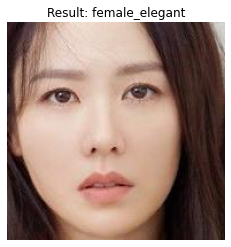

In [28]:
# Paths for image directory and model
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

IMDIR=sys.argv[1]
MODEL='/content/drive/MyDrive/smarcle_face_dataset/splitted/resnet50.pt'

# Load the model for testing
model = torch.load(MODEL)
model.eval()

# Class labels for prediction (우리 CLASS에 맞게 수정!)
class_names=['female_active', 'female_clean', 'female_cute', 'female_elegant', 'female_natural', 'female_sexy', 
             'male_active', 'male_clean', 'male_cute', 'male_elegant', 'male_natural', 'male_sexy']

# Preprocessing transformations
preprocess=transforms.Compose([
        transforms.Resize(size=64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Perform prediction and plot results
with torch.no_grad():
    img=Image.open('/content/drive/MyDrive/퍼스널컬러/가을웜톤/13..jpg_flip.jpg').convert('RGB') # 각자 가지고 있는 사진 넣어보세요
    inputs=preprocess(img).unsqueeze(0).to(DEVICE)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)   
    label=class_names[preds]
    plt.title("Result: "+label)
    plt.axis('off')
    plt.imshow(img)

## 코랩에서 웹캠 여는 코드인데 모델에 태우는건 모르겠다

In [ ]:
# 참고로 cv2.VideoCapture는 colab에서는 실행 안된다..
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))

  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))